In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn

from aiutils import load, classification_rate
from config import GameConfig
from enums import StartingSplit, FeatureType
from mlp import PredictorMLP
from mlprunner import train_mlp
from player import load_players
from predictor import sample_training_batch, test_mlp
from state import ReducedStateFeature
from supply import Supply

## Logistic Regression: Manual Weight Setting ##

We expect 100% classification accuracy on terminal states when the weights are equal to the VP value of the corresponding cards. 

In [97]:
config = GameConfig(split=StartingSplit.StartingRandomSplit, prosperity=False, num_players=2, feature_type=FeatureType.ReducedFeature, sandbox=True)
players = load_players(['BM', 'BM'], models=None, train=True)

In [98]:
X, y = sample_training_batch(1000, -1, config, players)  

100%|██████████| 1000/1000 [00:06<00:00, 143.71it/s]


In [99]:
# What are the class priors in the training sample? 
classes, rates = classification_rate(y)
classes, rates

(array([ 1, -1,  0]), array([0.437, 0.309, 0.254]))

In [100]:
train_y = y.copy()
train_y[train_y < 0] = 0

In [16]:
idxs = {'Copper': 0, 'Curse': 1, 'Estate': 2, 'Duchy': 3, 'Province': 4, 'Silver': 5, 'Gold': 6}

In [54]:
weights = np.zeros(config.feature_size)
weights[7 + 1] = -1
weights[7 + 2] = 1
weights[7 + 3] = 3
weights[7 + 4] = 6
weights[14 + 1] = 1
weights[14 + 2] = -1
weights[14 + 3] = -3
weights[14 + 4] = -6
weights

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  3.,  6.,  0.,
        0.,  0.,  1., -1., -3., -6.,  0.,  0.])

In [55]:
test_model = LogisticRegression()
test_model.coef_ = np.array([weights])
test_model.intercept_ = 0
test_model.classes_ = np.array([0, 1])
test_model.coef_

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  3.,  6.,  0.,
         0.,  0.,  1., -1., -3., -6.,  0.,  0.]])

In [56]:
test_model.score(X, train_y)

1.0

In [57]:
roc_auc_score(train_y, test_model.predict_proba(X)[:, 1])

1.0

## Predictor MLP Training ##

In [432]:
model = PredictorMLP(config.feature_size, (config.feature_size + 1) // 2, 1)
criterion = nn.BCELoss()

In [ ]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

In [438]:
model_name = 'r-r-mlp-pred-bce-100-100-1'
model_path = os.path.join(model_dir, model_name)

In [439]:
y1 = np.array(y, dtype=np.float32)
train_mlp(X, y1, model, criterion, epochs=100, save_epochs=10, model_name=model_name, path=os.path.join(model_dir, model_name))

100%|██████████| 100/100 [21:20<00:00, 12.81s/it]


In [329]:
y_pred = model(torch.tensor(X).cuda()).detach().cpu().numpy()
y_labels = np.array(y).reshape(y_pred.shape)

In [331]:
output = (y_pred > 0.5)
correct = (output == y_labels).sum() 
acc  = correct / len(y_labels)

In [332]:
acc

0.7853855651588282

In [87]:
mean_squared_error(y_pred, y_labels)

0.11117749924175713

## Logistic Model Training ##

Let's try a simpler logistic regression model.

In [24]:
from sklearn.linear_model import LogisticRegression

In [129]:
C = 10
max_iter = 10e5
model = LogisticRegression(max_iter=max_iter, C=C)

In [134]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')
model_name = 'r-r-logistic-pred-1k-terminal-C-10'
model_path = os.path.join(model_dir, model_name)
model_path

'/home/justiny/Documents/Projects/PyDominion/models/r-r-logistic-pred-1k-terminal-C-10'

In [135]:
model = load(model_path)
model

LogisticRegression(C=10, max_iter=1000000.0)

In [131]:
model = model.fit(X, train_y)
model.score(X, train_y)

1.0

In [71]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [124]:
agent_weights = model.coef_[0][7:14]
opp_weights = model.coef_[0][14:]
supply_weights = model.coef_[0][:7]
player_weight_diffs = agent_weights + opp_weights
cards = list(idxs.keys())

<AxesSubplot:>

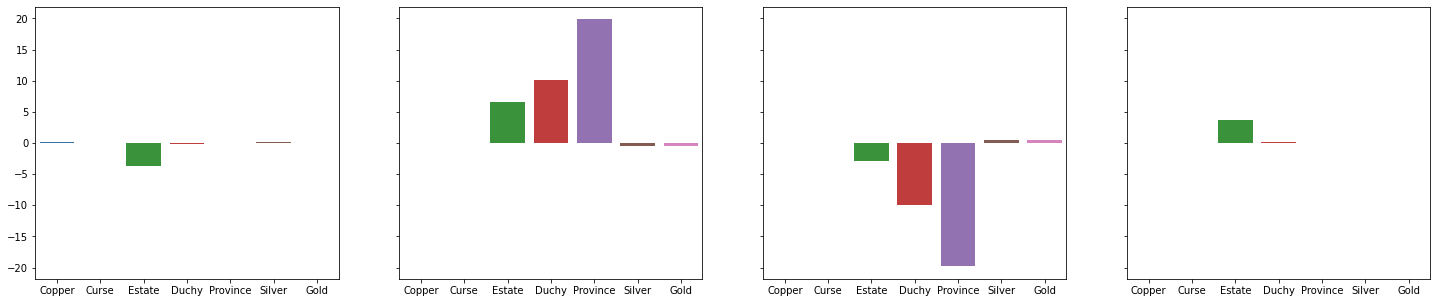

In [125]:
f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])
sns.barplot(x=cards, y=player_weight_diffs, ax=axes[3])

In [60]:
import pickle

In [132]:
pickle.dump(model, open(model_path, 'wb'))

## Logistic Model Testing ##
Let's test the logistic regression model.

In [138]:
test_config = GameConfig(split=StartingSplit.StartingRandomSplit, prosperity=False, num_players=2, feature_type=FeatureType.ReducedFeature, sandbox=True)
test_players = load_players(['BM', 'BM'], models=None, train=False)

In [139]:
test_X, test_y = sample_training_batch(1000, -1, test_config, test_players)

100%|██████████| 1000/1000 [00:06<00:00, 144.84it/s]


In [140]:
test_classes, test_rates = classification_rate(test_y)
test_classes, test_rates

(array([ 1, -1,  0]), array([0.456, 0.298, 0.246]))

In [141]:
wl_test_y = test_y.copy() 
wl_test_y[wl_test_y < 0] = 0

In [142]:
model.score(test_X, wl_test_y)

0.881

In [143]:
roc_auc_score(wl_test_y, model.predict_proba(test_X)[:, 1])

1.0

In [506]:
test_X_classes = reg.predict(test_X)
err = test_X[test_X_classes != test_y]
i=10

In [507]:
err[i][7:14], err[i][14:]

(array([7., 0., 3., 0., 4., 6., 5.], dtype=float32),
 array([ 7.,  0.,  3.,  0.,  4., 10.,  1.], dtype=float32))

In [508]:
reg.predict_proba([err[i]]), y[i]

(array([[0.46916815, 0.53083185]]), 1)

MLP Testing


In [ ]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')
model_name = 'r-r-mlp-pred-bce-10k-50--1'
model_path = os.path.join(model_dir, model_name)
model_path

In [591]:
model = torch.load(model_path, map_location='cpu')

In [592]:
y_test_pred = model(torch.tensor(test_X)).detach().cpu().numpy()
y_test_labels = np.array(test_y).reshape(y_test_pred.shape)

In [533]:
output = (y_test_pred > 0.5)
correct = (output == y_test_labels).sum() 
incorrect_flags = (output != y_test_labels).flatten()
incorrect = test_X[incorrect_flags]
incorrect_prob = y_test_pred[incorrect_flags]
acc  = correct / len(y_test_labels)

In [519]:
acc

0.983

In [580]:
i=14

In [581]:
incorrect[i][7:14], incorrect[i][14:], incorrect_prob[i]b

(array([7., 0., 4., 0., 4., 6., 4.], dtype=float32),
 array([7., 0., 3., 0., 4., 7., 4.], dtype=float32),
 array([0.01174975], dtype=float32))